<a href="https://colab.research.google.com/github/compi1234/spchlab/blob/main/lab02_spectrogram/MelScale.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Google Colab" title="Open in Google Colab"></a>
    
<div>
<img src=https://compi1234.github.io/spchlab/assets/tutorial_icon.jpg>
</div>

# The Mel Scale
___

### Background:  Frequency Sensitivity in Auditory Perception

The frequency range of the human ear spans from 20Hz to 20kHz.
Many properties of our hearing system are easier understood in the frequency domain than in the time domain, which makes Fourier spectrograms a favorite representation of acoustic signals.

However, Fourier analysis misses some important characteristics of hearing, especially the nonlinear characterisitics of frequency sensitivity:   
- frequencies close to each interfere a lot, while frequencies far apart are quite independent   
- the frequency range over which interference is prominent is small at low frequencies and much higher at high frequencies   

Based on diverse perceptual experiments it was therefore suggested to model the human hearing system using a set of non uniform auditory (band-pass) filters.  The bandwidth of these filters is called the *critical bandwidth*.  

### Auditory Filters in the cochlea

Processing in the cochlea is easiest understood as an auditory filterbank. Individual auditory nerve fibers are sensitive only to a narrow frequency range centered around the *characteristic frequency* of the corresponding nerve fiber.  Both the density of these filters and their bandwidth follow the critical band characteristics (linear at low, logarithmic at high frequencies)


In [1]:
# Uncomment the pip install command to install pyspch -- it is required!
#!pip install git+https://github.com/compi1234/pyspch.git
try:
    import pyspch
    print("pyspch was found - you are all set to continue")
except ModuleNotFoundError:
    try:
        print(
        """
        WARNING: pyspch was not found !!
        To enable this notebook on platforms as Google Colab, 
        install the pyspch package and dependencies by running following code:

        !pip install git+https://github.com/compi1234/pyspch.git
        """
        )
    except ModuleNotFoundError:
        raise

pyspch was found - you are all set to continue


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams["figure.figsize"] = (12,4)
mpl.rcParams["savefig.dpi"] = 100
mpl.rcParams["savefig.bbox"] = 'tight'
# When the SAVE_FIG flag is set, then pictures are save along the way
SAVE_FIG = False
import librosa
from pyspch.sp.mel import *

## 1. Modeling the Mel Scale

From the above it is obvious that there is not such a thing as **THE** auditory frequency scale as different experiments lead to slightly different scales:  **MEL** scale, **BARK** scale, the **ERB** scale, **1/3th octave filterbanks**, ... 

Putting small differences aside, it is often sufficient to reason as follows:   
- linear up to 1kHz with a bandwidth of 100Hz  
- logartihmic above 1 kHz
- resulting in 24 critical bands spanning the auditory frequency range

In the sequel we will use the term **mel-scale** as a generic term, and 
in order to compare different implementations we rescale each such that frequency is mapped to a number corresponding for critical band number, in particular we always map 1000.0Hz to 10.0 mel.  (Note: this is our own way of standardizing different mappings; there is no established standard)

The functions mel2hz() and hz2mel() implement a few of these mel-scale variants:
- DM(Davis and Mermelstein): as defined in the 1980 paper in which they introduce the concept of mel cepstra, one of the oldest handy approximations
- HTK: as used in the HTK and KALDI packages, based on a formula proposed by Gunnar Fant in 1959
- Slaney: as used in the MATLAB Auditory Toolbox and also used as default in the librosa library.

In Python packages librosa and torchaudio both the Slaney and HTK scales are implemented.

All 'mel'-centered code is grouped in *mel.py* in this folder 

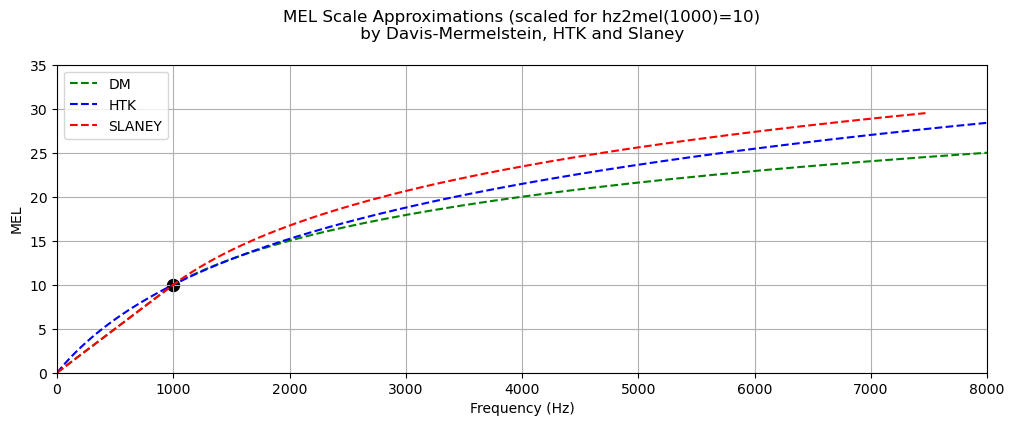

In [3]:
mels = np.arange(0.,30.,.5)
freqs_sl = mel2hz(mels,scale='SLANEY')
freqs_htk = mel2hz(mels,scale='HTK')
freqs_dm = mel2hz(mels,scale='DM')

fig1,ax1 = plt.subplots()

ax1.plot(freqs_dm,mels,'--',color='g')
ax1.plot(freqs_htk,mels,'--',color='b')
ax1.plot(freqs_sl,mels,'--',color='r')

ax1.legend(['DM','HTK','SLANEY']);

ax1.grid()
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel("MEL")
ax1.tick_params(axis='x')
ax1.set_title("MEL Scale Approximations (scaled for hz2mel(1000)=10)\n by Davis-Mermelstein, HTK and Slaney \n");
ax1.set_ylim([0.,35.])
ax1.set_xlim([0,8000])

ax1.scatter(1000,10,marker='o',s=75,color='k');
if SAVE_FIG : 
    fig1.savefig("figures/mel_scale_3")

## 2. Mel scale and Equivalent Bandwidth
Another way to understand the mel scale is by thinking in terms of equivalent perceptual bandwidths; i.e. the range over which there is strong interference.
Below 1kHz this bandwidth is estimated to be roughly 100Hz and at higher frequencies this bandwidth linearly increases.

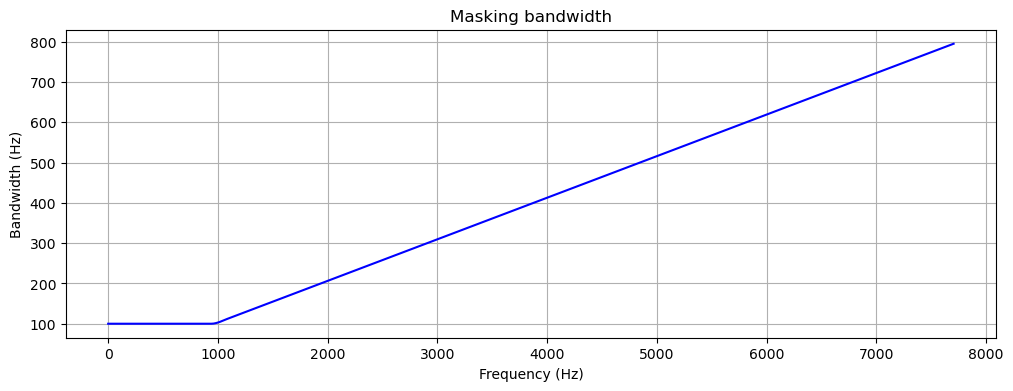

In [4]:
bw_mel = 1.
mels = np.arange(0.,30.,.2)
freqs = mel2hz(mels)
lows = mel2hz(mels-bw_mel/2)
highs = mel2hz(mels+bw_mel/2)
bw_hz = (highs-lows)
fig,ax = plt.subplots()
ax.plot(freqs,bw_hz)
ax.set_title("Masking bandwidth")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Bandwidth (Hz)")
ax.grid('on')

### Labeling a mel axis with 'mel' or 'Hz' ??
Because the lack of standardization of a mel scale, we see in practice that people use 'Hz' as labels on the frequency axis and
that the non linear behavior is obvious from the tick values

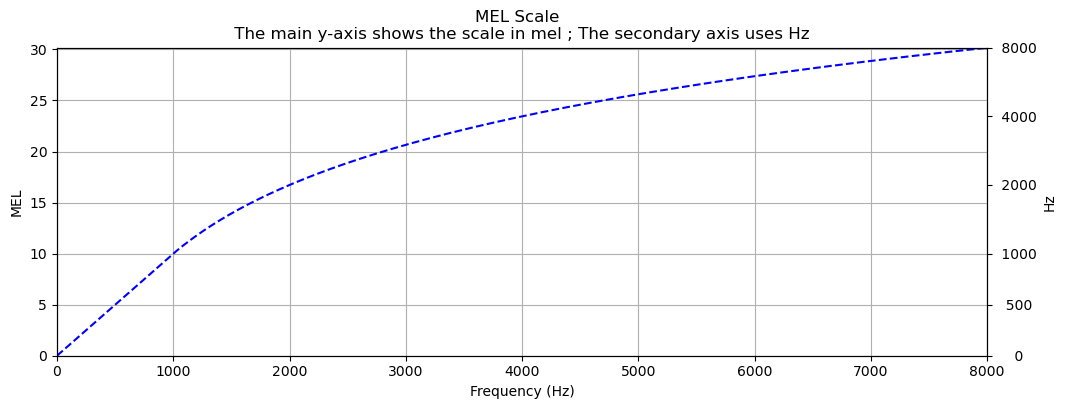

In [5]:
mels = np.arange(0.,31.,.1)
freqs = mel2hz(mels)
#
fig,ax1 = plt.subplots()
ax1.plot(freqs,mels,'--',color='b')
ax1.grid()
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel("MEL")
ax1.set_title('MEL Scale  \n The main y-axis shows the scale in mel ; The secondary axis uses Hz ');

x_lim = np.asarray([0.,8000.])
y_lim = hz2mel(x_lim)
ax1.set_ylim(y_lim)
ax1.set_xlim(x_lim)

ax2 = ax1.twinx()
#specify y2_ticks at specific Hz locations
y2_ticks = hz2mel([0,500,1000,2000,4000,8000]) 
### or use tick marks as on y1
# y2_ticks = ax1.get_yticks()
#
y2_ticklabels = ['{:.0f}'.format(mel2hz(x)).rjust(5) for x in y2_ticks]

# (matplotlib programming note) 
# you need to do the following lines in STRICT order to avoid warnings and/or plotting mistakes
# 1. set the y_ticks, 2. set the y_ticklables, 3. set the y_lim identical to axis1
ax2.set_yticks(y2_ticks)
ax2.set_yticklabels(y2_ticklabels)
ax2.set_ylim(y_lim)
ax2.set_ylabel( 'Hz' );
#SAVE_FIG = True
if SAVE_FIG : 
    fig.savefig("figures/mel_scale")

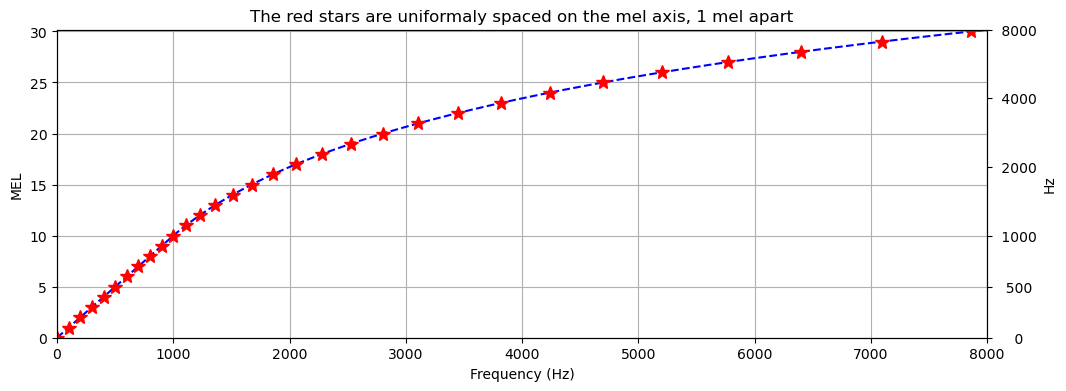

In [6]:
mel_crit = np.arange(0.,31.,1)
freq_crit = mel2hz(mel_crit)

ax1.plot(freq_crit,mel_crit,'*',color='r',ms=10)
ax1.set_title('The red stars are uniformaly spaced on the mel axis, 1 mel apart');
display(fig)
if SAVE_FIG : 
    fig.savefig("figures/mel_scale_critb1")

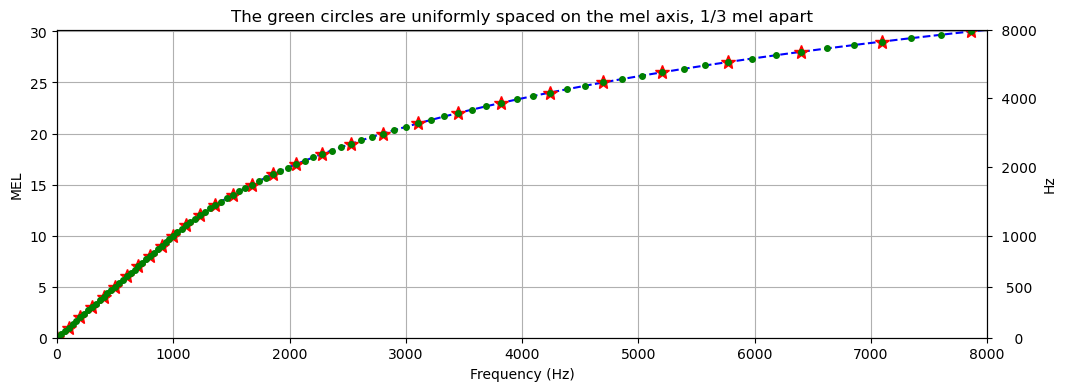

In [7]:
mel_crit3 = np.arange(0.,31.,1/3.)
freq_crit3 = mel2hz(mel_crit3)
ax1.plot(freq_crit3,mel_crit3,'o',color='g',ms=4)
ax1.set_title('The green circles are uniformly spaced on the mel axis, 1/3 mel apart');
if SAVE_FIG : 
    fig.savefig("figures/mel_scale_critb3")
display(fig)

## 2. MEL FILTERBANK

The primary purpose of the mel-scale in speech processing is to map of a **Fourier spectrum** to a **mel spectrum** .
In practice we achieve this by running a Fourier Spectrum through a **mel filterbank**, where the individual channels in 
the filterbank are spaced uniformly on the mel scale and where the width of the filters is proportional to the critical bandwidth.

In the example below we show a common mel filterbank design
- 80 filters cover the main frequency range of speech (50-6500 Hz)
- The filters are triangular in shape and have a 50% overlap
- With these design parameters
    - filterbank spacing is 1/3 mel
    - frequency resolution in the low frequency range is as in Fourier analysis
    - frequency resolution in the high frequency range decreases logarithmically

In [8]:
# plot the design center frequencies and bandwidth of mel filterbank
def plot_fb_concept(freqs,sr,colormap='hsv',bwscale=.5,Labels=True):
    mels = hz2mel(freqs)
    nb = len(freqs)-2
    cf = range(1,nb+1)
    low = range(0,nb)
    high = range(2,nb+2)

    fr_low= freqs[low]
    fr_high = freqs[high]
    fr_cf = freqs[cf]
    mel_cf = mels[cf]
    
    # adjust plotted bandwidth
    fr_low = bwscale*fr_low + (1-bwscale)*fr_cf
    fr_high = bwscale*fr_high + (1-bwscale)*fr_cf
    
    fig,ax = plt.subplots()
    colors = (mpl.colormaps[colormap]( np.linspace(0, 1, nb)))
    #ax.scatter(fr_cf,np.arange(0,nb),marker='o',s=30,color=colors)
    for i in range(nb):
        plt.plot([fr_low[i],fr_high[i]],[mel_cf[i],mel_cf[i]],color=colors[i],linewidth=3)
    ax.grid('on')
    ax.set_xlim([0.,sr/2])
    ylim = [0,hz2mel(sr/2)]
    ax.set_ylim(ylim)
    if Labels:
        ax.set_xlabel('Frequency (Hz)')
        ax.set_ylabel("MEL" )
        ax.set_title("%d channel MEL FILTERBANK " % (nb) )
    ax2 = ax.twinx()
    # define y2_ticks explicitly as y_ticks on original axis may have out of domain (negative) values
    y2_ticks = [0,500,1000,2000,4000,8000] # np.arange(0,nb,5*(1+nb//40))
    y2_ticklabels = ['{:.0f}'.format(i).rjust(5) for i in y2_ticks] 
    
    # (matplotlib programming note) 
    # you need to do the following lines in STRICT order to avoid warnings and/or plotting mistakes
    # 1. set the y_ticks, 2. set the y_ticklables, 3. set the y_lim identical to axis1
    ax2.set_yticks(hz2mel(y2_ticks))
    ax2.set_yticklabels(y2_ticklabels)
    ax2.set_ylim(ylim)
    if Labels:
        ax2.set_ylabel( 'Hz' );

MEL FBANK Center Frequencies


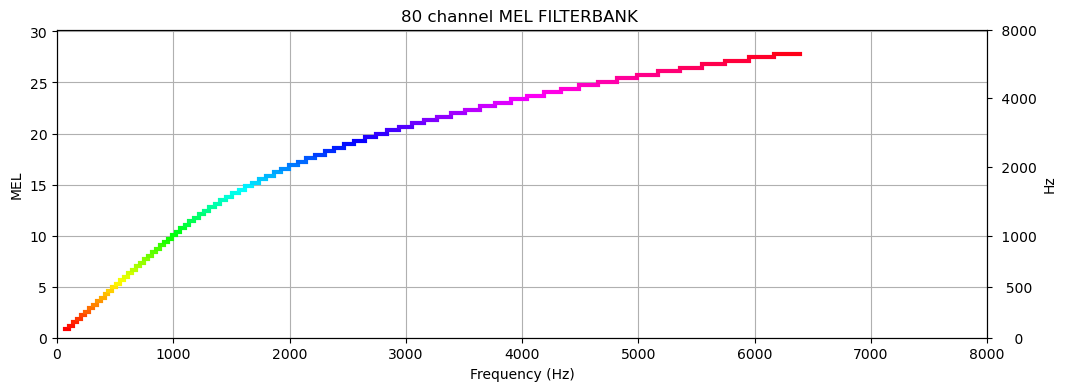

In [9]:
##  DESIGN PARAMETERS - MINIMAL NUMBER OF CHANNELS  ########
sr = 16000         # sampling rate, typically 16 or 8 kHz
n_mels = 80        # the number of mel filterbanks should not be less than 24 with 16kHz sampling or 20 channels with 8kHz sampling
                   # such design has roughly filterbank widths equal to 1 mel; less channels would imply wider bands that would smear information too much
                   # and should be no more than 64 for sr=8000, can go to 100 for sr=16000
fmin = 50.         # lower cutoff can be set to 0Hz, but 50Hz is more common in practice is there is no useful acoustic energy below 50Hz
fmax = 6500.       # higher cutoff for filterbank.  6500.Hz is an arbitrary value; it was chosen to make the first 20 bands fit nicely into the 4kHz range
##########

freqs,fbank = mel_filterbank(n_mels=n_mels,sr=sr,fmin=fmin,fmax=fmax) 
print("MEL FBANK Center Frequencies")
#print(freqs[1:-1],"\n")
#

name = "figures/mel_filterbank"+str(n_mels)+"_"
plot_fb_concept(freqs,sr=sr,Labels=True)
if SAVE_FIG : plt.savefig(name+"cf1")

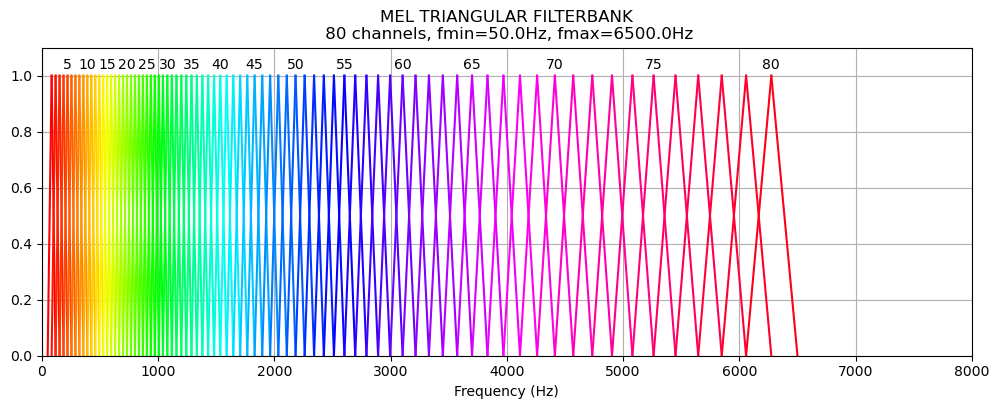

In [10]:
fig,ax = plt.subplots()
plot_filterbank(freqs,sr=sr,ax=ax)
for i in range(5,n_mels+1,5):
    ax.text(freqs[i],1.025,str(i),ha='center')
if SAVE_FIG : plt.savefig(name+"fb1")

## 3. DESIGNING A MEL FILTERBANK

The design of a mel filterbank is not something fixed.
In this section we explore a range of parameter settings. 
Some of the options are:
- frequency range specification: 
It is well known that the data at the fringes of the frequency range is not be very reliable. At very low frequencies there may only be 50Hz hum from electrical equipment and at high frequencies the content is highly dependent on the sampling rate and the anti-aliasing filtering that was used.  Therefore it is sometimes decided to throw away one or several of the lowest and highest bands in speech recognition systems or alternatively to limit the frequency range of the filterbank
- frequency resolution:
The filterbank as designed above maintains frequency resolution from the Fourier analysis in the lower range.  The result is that both spectral envelope and pitch harmonics 'percolate' through the filterbank; i.e. you still see the harmonic structure of voice speech.   When we are just interested in spectral envelope or if further on we keep a low dimensional cepstral representation, then this high resolution representation is not necessary.
In those situations a so called 'low resolution' filterbank may suffice.  However we should never go lower than the 'critically' spaced mel filterbank, i.e. maintaining a resolution of at least 1 mel.

#### DESIGN TASKS: 
1.  Design a filterbank with critical band spacing, therefore the design parameters need to be 24 channels for a sampling rate of 16kHz and default fmin and fmax
2.   Design a similar filterbank for a sampling rate of 8kHz. You need to adjust fmax to 4000 Hz or a bit below. Verify that you achieve the same resolution as above by using only 20 channels
3.    Have a look at the detailed design for the reference filterbank we designed above


The figures below will show  
(1) designed centerfrequencies and bandwidth      
(2) designed filterbank (target)   
(3) actual interpolation weights to apply to an FFT spectrum to compute a mel spectrum and simulate the filterbank above


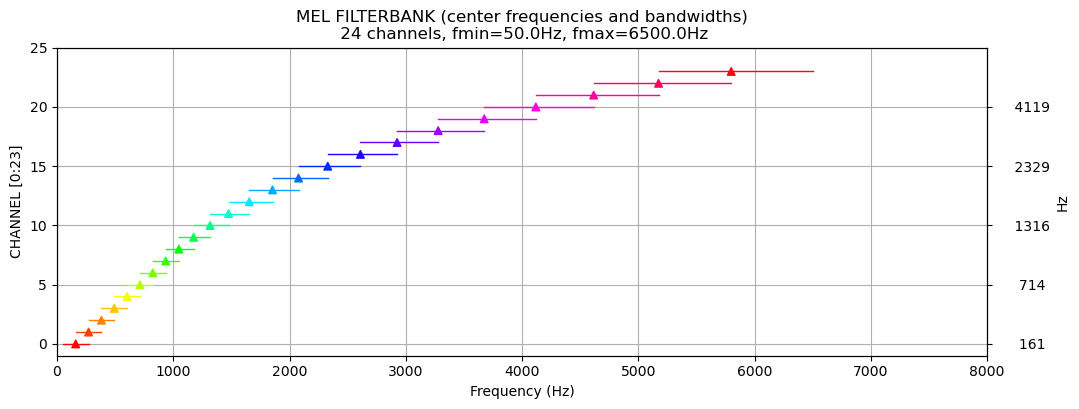

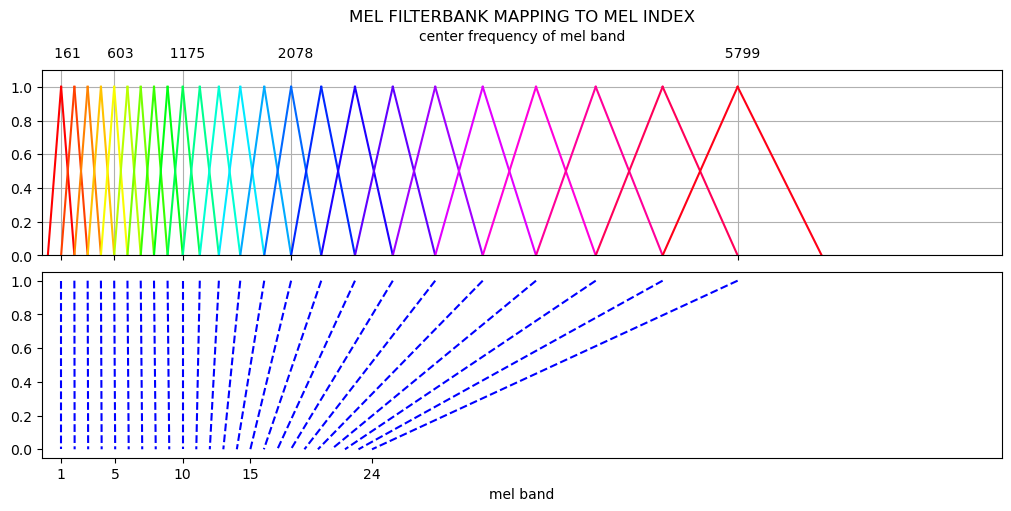

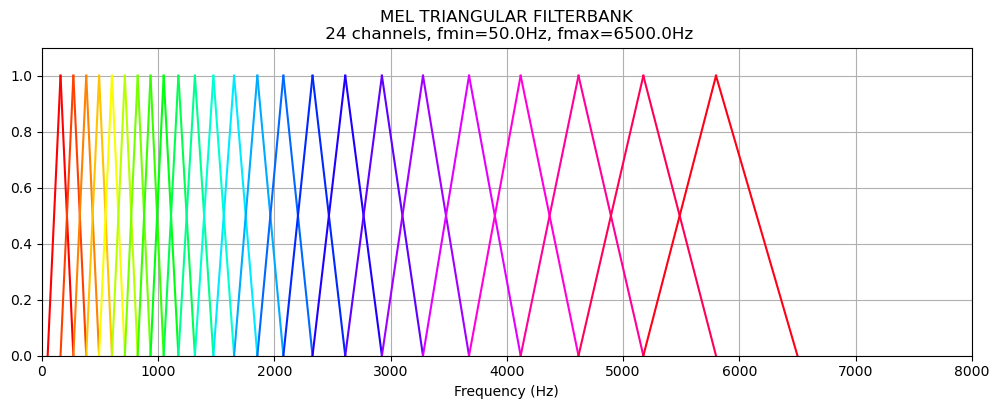

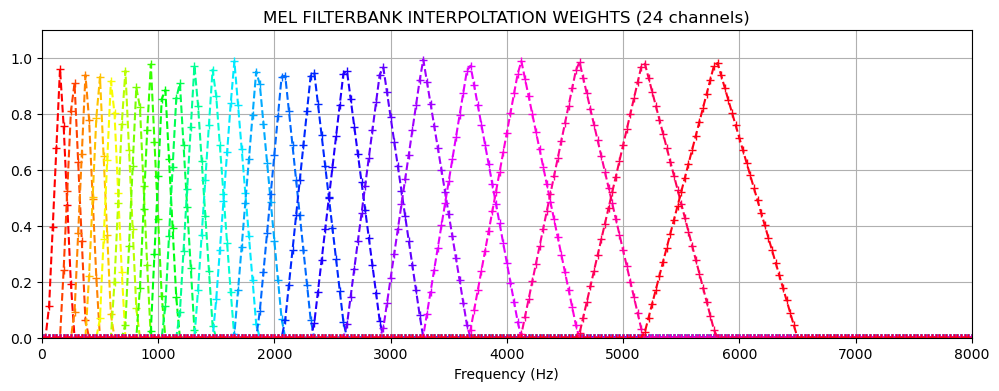

In [11]:
##  DESIGN PARAMETERS - MINIMAL NUMBER OF CHANNELS  ########
sr = 16000         # sampling rate, typically 16 or 8 kHz
n_mels = 24        # the number of mel filterbanks should not be less than 24 with 16kHz sampling or 20 channels with 8kHz sampling
                   # such design has roughly filterbank widths equal to 1 mel; less channels would imply wider bands that would smear information too much
                   # and should be no more than 64 for sr=8000, can go to 100 for sr=16000
fmin = 50.         # lower cutoff can be set to 0Hz, but 50Hz is more common in practice is there is no useful acoustic energy below 50Hz
fmax = 6500.       # higher cutoff for filterbank.  6500.Hz is an arbitrary value; it was chosen to make the first 20 bands fit nicely into the 4kHz range
##########

freqs,fbank = mel_filterbank(n_mels=n_mels,sr=sr,fmin=fmin,fmax=fmax) 
#print("MEL FBANK Center Frequencies")
#print(freqs[1:-1],"\n")
#

name = "figures/mel_filterbank"+str(n_mels)+"_"
plot_filterbank_cf_bw(freqs,sr=sr)
if SAVE_FIG : plt.savefig(name+"cf")
plt.show()
plot_filterbank_mapping(freqs,sr=sr)
if SAVE_FIG : plt.savefig(name+"map")
plt.show()
plot_filterbank(freqs,sr=sr)
if SAVE_FIG : plt.savefig(name+"filt")
plt.show()
plot_filterbank_weights(fbank,sr=sr)
if SAVE_FIG : plt.savefig(name+"coef")
plt.show()